### Introduction 

The main goal of the following class is an effective way of feature engineering. Since this dataset has lots of logs of users, then some features have constant values per user, but some features are variable for one user. 

Firstly, during a feature engineering we have to be very accurate to avoid any sorts of leakage, which can appear accidently, when you prepare your data. Secondly, we need to do a lot of tests of our features for developing good model. Due to the size of data, I need to optimize steps of my feature engineering and constructing datasets to fit model, because time of feature processing takes lots of time

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook as tqdm
from time import time
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from glove import Corpus, Glove
from multiprocessing import Pool
%matplotlib inline

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
run utils.py

In [3]:
run data.py

In [4]:
run Feature_processing.py

In [5]:
DATA = pd.read_pickle('../Data_original/All_Data.pkl')
targets = pd.read_pickle("../Data_original/Targets.pkl")

In [6]:
class Data():
    def __init__(self, data, target):
        self.data = self._clear_data(data)
        self._add_additional_features()
        
        self.target = target[['ID', 'target']]
        self._get_train_test_split()
        
    def _clear_data(self, data):
        message = 'Input data of shape ' + str(data.shape) + ' converted to data of shape '
        x = data.NUMMER.value_counts(ascending=True).reset_index()
        x = x[x.NUMMER<=2]
        data = data[~data.NUMMER.isin(x['index'])]
        data = data[data.KORREKTUR>=0.][data.BETRAG>=0.][data.VISITS<=25]
        data.NUMMER.fillna('NUMMER_NAN', inplace=True)
        data.ART.fillna('ART_NAN', inplace=True)
        
        message += str(data.shape)
        print(message)
        return data
    
    def _separate_into_train_test(self, data):
        train, test = data[data.ID.isin(self.id_train)], data[data.ID.isin(self.id_test)]
        return train, test 
    
    def _is_sorted_data_by_id(self, data):
        list_of_id = data.ID.apply(lambda dt: int(dt[3:])).values
        bools = list_of_id[:-1] > list_of_id[1:]
                
        if np.sum(bools) > 0:
            print('Data is not sorted')
            data = self._sort_data_by_id(data)
            print('Data is sorted now')
            return data
        else:
            return data
                    
    def _sort_data_by_id(self, data):
        data['ID_int'] = data.ID.apply(lambda dt: int(dt[3:]))
        data = data.sort_values('ID_int')
        return data.drop(['ID_int'], axis=1)
    
    def _get_train_test_split(self, test_ID_size=0.2, test_Time_size=0.25):
        
        assert 0 < test_ID_size < 1 or 0 < test_Time_size < 1, 'Test size must be between 0 and 1'
        
        train, test = separate_data(self.data, self.target, 
                                    test_ID_size=test_ID_size, 
                                    test_Time_size=test_Time_size)
        

        self.id_train = sort_indices(train.ID.unique()) 
        self.id_test  = sort_indices(test.ID.unique()) 
        
        self.df_id_train = pd.DataFrame(self.id_train, columns=['ID'])
        self.df_id_test  = pd.DataFrame(self.id_test , columns=['ID'])
        
        self.X_train = train
        self.X_test  = test
        
        return train, test
    
            
    
    def _add_additional_features(self):
        self.data = self.data.sort_values(by='BETRAG')
        self.data['b_hist'] = adaptive_boards(self.data.BETRAG.values, N=1500)
        self.data['b_hist'] = 'b_' + self.data['b_hist'] 
        
        self.data = self.data.sort_values(by='FAKTOR')
        self.data['f_hist'] = adaptive_boards(self.data.FAKTOR.values, N=25)
        self.data['f_hist'] = 'f_' + self.data['f_hist'] 
        
#         self.data = self.data.sort_values(by='ANZAHL')
#         self.data['a_hist'] = adaptive_boards(self.data.ANZAHL.values, N=25)
        
        
    def simple_features(self, save=False):
        data = self.data.drop_duplicates(subset=['ID'])[['ID', 'RECHNUNGSBETRAG', 'ALTER', 'GESCHLECHT', 'VERSICHERUNG', 'VISITS']].reset_index(drop=True)        
        data.RECHNUNGSBETRAG = np.log(data.RECHNUNGSBETRAG - np.min(data.RECHNUNGSBETRAG, 0) +  1)
        
        train, test = self._separate_into_train_test(data)
        if save: save_features(train, test, 'simple_features')
        return train, test
            
    def transform_betrag_histogram(self, save=False, name='betrag_histogram'):
        train = self.X_train.groupby('ID').b_hist.apply(lambda dt: (dt +' ').sum())
        test = self.X_test.groupby('ID').b_hist.apply(lambda dt: (dt +' ').sum())
       
        train, test = fit_transform_tf_idf(train, test, 'betrag')   
        
        if save: save_features(train, test, 'betrag_histogram')

    def transform_faktor_histogram(self, save=False, name='betrag_histogram'):
        train = self.X_train.groupby('ID').f_hist.apply(lambda dt: (dt +' ').sum())
        test = self.X_test.groupby('ID').f_hist.apply(lambda dt: (dt +' ').sum())
               
        train, test = fit_transform_tf_idf(train, test, 'faktor')
        
        if save: save_features(train, test, 'faktor_histogram')
        
    def transform_anzahl_histogram(self, save=False, name='anzahl_histogram'):        
        train = self.X_train.groupby('ID').a_hist.apply(lambda dt: (dt +' ').sum())
        test = self.X_test.groupby('ID').a_hist.apply(lambda dt: (dt +' ').sum())
        
        train, test = fit_transform_tf_idf(train, test, 'anzahl')
        
        if save: save_features(train, test, 'anzahl_histogram')

    def transform_faktor_stats(self, save=False, name='faktor_stats'):
        faktor_mean = self.data.groupby(['ID'])['FAKTOR'].mean()
        faktor_std = self.data.groupby(['ID'])['FAKTOR'].std().fillna(0)
        faktor_min = self.data.groupby(['ID'])['FAKTOR'].min()
        faktor_max = self.data.groupby(['ID'])['FAKTOR'].max()
        faktor_median = self.data.groupby(['ID'])['FAKTOR'].median()

        faktor_all = pd.concat([faktor_mean, faktor_std, faktor_min, faktor_max, faktor_median], axis=1, keys=
                  ['FAKTOR_mean', 'FAKTOR_std', 'FAKTOR_min', 'FAKTOR_max', 'FAKTOR_median']).reset_index()
    
        
        train, test = self._separate_into_train_test(faktor_all)
        if save: save_features(train, test, name)

        return faktor_all
    
    def transform_typ_stats(self, save=False, name='typ_stats'):
        self.data.TYP.fillna(-1, inplace=True)
        typ_mean = self.data.groupby(['ID'])['TYP'].mean()
        typ_std = self.data.groupby(['ID'])['TYP'].std().fillna(0)
        typ_min = self.data.groupby(['ID'])['TYP'].min()
        typ_max = self.data.groupby(['ID'])['TYP'].max()
        typ_median = self.data.groupby(['ID'])['TYP'].median()

        typ_all = pd.concat([typ_mean, typ_std, typ_min, typ_max, typ_median], axis=1, keys=
                  ['TYP_mean', 'TYP_std', 'TYP_min', 'TYP_max', 'TYP_median']).reset_index()
        
        train, test = self._separate_into_train_test(typ_all)
        if save: save_features(train, test, name)
            
        return typ_all
    
    def transform_betrag_stats(self, save=False, name='betrag_stats'):
                
        betrag_mean = self.data.groupby(['ID'])['BETRAG'].mean()
        betrag_std = self.data.groupby(['ID'])['BETRAG'].std().fillna(0)
        betrag_min = self.data.groupby(['ID'])['BETRAG'].min()
        betrag_max = self.data.groupby(['ID'])['BETRAG'].max()
        betrag_median = self.data.groupby(['ID'])['BETRAG'].median()
        betrag_log_sum = self.data.groupby(['ID'])['BETRAG'].sum()
        betrag_log_sum = np.log(betrag_log_sum - np.min(self.data.RECHNUNGSBETRAG, 0 ) + 1)

        betrag_all = pd.concat([betrag_mean, betrag_std, betrag_min, betrag_max, betrag_median, betrag_log_sum],
                        axis=1, 
                        keys= ['BETRAG_mean', 'BETRAG_std', 'BETRAG_min', 'BETRAG_max', 
                               'BETRAG_median', 'BETRAG_log_sum']).reset_index()
        
        train, test = self._separate_into_train_test(betrag_all)
        if save: save_features(train, test, name)
            
        return betrag_all
    
    def transform_nummer_tf_idf(self, save=False):
        
        train = self.X_train.groupby('ID').NUMMER.apply(lambda dt: (dt +' ').sum())
        test = self.X_test.groupby('ID').NUMMER.apply(lambda dt: (dt +' ').sum())
        
        train, test = fit_transform_tf_idf(train, test, 'nummer')
                
        if save: save_features(train, test, 'nummer_tfidf')

    def transform_nummer_kat_tf_idf(self, save=False):
        train = self.X_train.groupby('ID').NUMMER_KAT.apply(lambda dt: (dt +' ').sum())
        test = self.X_test.groupby('ID').NUMMER_KAT.apply(lambda dt: (dt +' ').sum())

        train, test = fit_transform_tf_idf(train, test, 'nummer_kat')   
        
        if save: save_features(train, test, 'nummer_kat_tfidf')
        
    def transform_art_tf_idf(self, save=False):
        train = self.X_train.groupby('ID').ART.apply(lambda dt: (dt +' ').sum())
        test = self.X_test.groupby('ID').ART.apply(lambda dt: (dt +' ').sum())

        train, test = fit_transform_tf_idf(train, test, 'art')   
        
        if save: save_features(train, test, 'art_tfidf')

    def transform_leistung_tf_idf(self, save=False):
        train = self.X_train.groupby('ID').LEISTUNG.apply(lambda dt: (dt +' ').sum())
        test = self.X_test.groupby('ID').LEISTUNG.apply(lambda dt: (dt +' ').sum())

        train, test = fit_transform_tf_idf(train, test, 'leistung')   
        
        if save: save_features(train, test, 'leistung_tfidf')
        
        
    def transform_nummer_doc2vec(self, save=False):
        train = self.X_train.groupby('ID').NUMMER.apply(lambda dt: (dt +' ').sum())
        test = self.X_test.groupby('ID').NUMMER.apply(lambda dt: (dt +' ').sum())
        
        
        tagged_data = [TaggedDocument(words=word_tokenize(sent.lower()), tags=[str(i)]) for i, sent in enumerate(train.values)]
        
        max_epochs = 4
        vec_size = 200

        model = Doc2Vec(vector_size=vec_size,
                        min_count=0, dm=0, alpha=0.025, min_alpha=0.00025, workers = Pool()._processes)

        model.build_vocab(tagged_data)
        
        for epoch in range(max_epochs):
            print('iteration {0}'.format(epoch))
            model.train(tagged_data,
                        total_examples=model.corpus_count,
                        epochs=model.iter)
            model.alpha -= 0.0002
            model.min_alpha = model.alpha

        #model.save("d2v.model")
        
        train_vectors = self.get_vectors(model, train.values)
        test_vectors = self.get_vectors(model, test.values)
        
        name = 'NUMMER_embed'
        names = [name + '_' + str(i) for i in range(vec_size)]
        
        df_train = pd.DataFrame(train_vectors, columns=names)
        train = pd.concat([pd.Series(train.index), df_train], axis=1)
        
        df_test = pd.DataFrame(test_vectors, columns=names)
        test = pd.concat([pd.Series(test.index), df_test], axis=1)
        
        if save: save_features(train, test, 'doc2vec_2')        
        
    def transform_nummer_glove(self, save=False):
        train = self.X_train.groupby('ID').NUMMER.apply(lambda dt: (dt +' ').sum())
        test = self.X_test.groupby('ID').NUMMER.apply(lambda dt: (dt +' ').sum())
        
        tagged_data_train = [i.lower().split(' ')[:-1] for i in train.values]
        tagged_data_test  = [i.lower().split(' ')[:-1] for i in test.values]
                
        max_epochs = 100
        vec_size = 200
        
        corpus = Corpus()
        corpus.fit(tagged_data_train, window=10)
        
        model = Glove(no_components=vec_size, learning_rate=0.05)

        model.fit(corpus.matrix, epochs=max_epochs, no_threads=Pool()._processes, verbose=True)
        model.add_dictionary(corpus.dictionary)
        
        train_vectors = self.get_vectors_glove(model, tagged_data_train)
        test_vectors = self.get_vectors_glove(model, tagged_data_test)
        
        name = 'NUMMER_embed_glove'
        names = [name + '_' + str(i) for i in range(vec_size)]
        
        df_train = pd.DataFrame(train_vectors, columns=names)
        train = pd.concat([pd.Series(train.index), df_train], axis=1)
        
        df_test = pd.DataFrame(test_vectors, columns=names)
        test = pd.concat([pd.Series(test.index), df_test], axis=1)
        
        if save: save_features(train, test, 'glove')
            
            
    def glove_all(self, save=False):
        d = self.data
        
        d_text = d.NUMMER + ' ' + d.NUMMER_KAT + ' ' + d.LEISTUNG  + ' '+ d.b_hist + ' '+ d.f_hist
        
        data = pd.concat([d.ID, d_text], axis=1)
        data.columns = ['ID', 'INFO']
        data = data.groupby('ID').INFO.apply(lambda dt: (dt +' ').sum())
        
        train = data[self.df_id_train.ID].dropna()
        test = data[self.df_id_test.ID].dropna()
        
        tagged_data_train = [i.lower().split(' ')[:-1] for i in train.values]
        tagged_data_test  = [i.lower().split(' ')[:-1] for i in test.values]
                
        max_epochs = 300
        vec_size = 200
        
        corpus = Corpus()
        corpus.fit(tagged_data_train, window=10)
        
        model = Glove(no_components=vec_size, learning_rate=0.05)

        model.fit(corpus.matrix, epochs=max_epochs, no_threads=Pool()._processes, verbose=True)
        model.add_dictionary(corpus.dictionary)
        
        train_vectors = self.get_vectors_glove(model, tagged_data_train, vec_size=vec_size)
        test_vectors = self.get_vectors_glove(model, tagged_data_test, vec_size=vec_size)
        
        name = 'NUMMER_embed_glove_all'
        names = [name + '_' + str(i) for i in range(vec_size)]
        
        df_train = pd.DataFrame(train_vectors, columns=names)
        train = pd.concat([pd.Series(train.index), df_train], axis=1)
        
        df_test = pd.DataFrame(test_vectors, columns=names)
        test = pd.concat([pd.Series(test.index), df_test], axis=1)
        
        if save: save_features(train, test, 'glove_all')
        
            
    def get_vectors_glove(self, model, sentences, vec_size=200):
        
        vectors = []
        for sent in sentences:
            infered_vectors = np.zeros(vec_size)
            for word in sent:
                if word in model.dictionary:
                    infered_vectors += model.word_vectors[model.dictionary[word]]
                
            vectors.append(infered_vectors)
            
        return np.array(vectors)
        
            
    def get_vectors(self, model, sentences):
        vectors = []
        for i, s in enumerate(sentences):
            tokenized_vector = word_tokenize(s.lower())
            infered_vector = model.infer_vector(tokenized_vector, steps=6)
            vectors.append(infered_vector)

        return np.array(vectors)


    def fit(self):
        t = time()
        self.simple_features(save=True)
        print(time() - t)
        self.transform_betrag_histogram(save=True)
        print(time() - t)
        self.transform_faktor_histogram(save=True)
        print(time() - t)
        self.glove_all(save=True)
        print(time() - t)
        self.transform_nummer_doc2vec(save=True)
        print(time() - t)
        self.transform_faktor_stats(save=True)
        print(time() - t)
        self.transform_typ_stats(save=True)
        print(time() - t)
        self.transform_betrag_stats(save=True)
        print(time() - t)
        self.transform_nummer_tf_idf(save=True)
        print(time() - t)
        self.transform_nummer_kat_tf_idf(save=True)
        print(time() - t)
        self.transform_art_tf_idf(save=True)
        print(time() - t)
        self.transform_leistung_tf_idf(save=True)
        print(time() - t)

In [7]:
d = Data(DATA, targets)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Input data of shape (3275027, 18) converted to data of shape (2431370, 18)
Average length of records in Train data:  6.8
Average length of records in Test  data:  6.79
0.0% of data was dropped


In [12]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers.embeddings import Embedding

Using TensorFlow backend.


In [110]:
%%time
train = d.X_train.sort_values('Time').groupby('ID').NUMMER.apply(lambda dt: (dt +' ').sum())
test = d.X_test.sort_values('Time').groupby('ID').NUMMER.apply(lambda dt: (dt +' ').sum())
print('Done')

tagged_data_train = [i.lower().split(' ')[:-1] for i in train.values]
tagged_data_test  = [i.lower().split(' ')[:-1] for i in test.values]

max_epochs = 100
vec_size = 50

corpus = Corpus()
corpus.fit(tagged_data_train, window=10)

model = Glove(no_components=vec_size, learning_rate=0.05)

model.fit(corpus.matrix, epochs=max_epochs, no_threads=Pool()._processes, verbose=False)
model.add_dictionary(corpus.dictionary)

Done
CPU times: user 3min 9s, sys: 7.02 s, total: 3min 16s
Wall time: 2min 12s


Process ForkPoolWorker-144:
Process ForkPoolWorker-139:
Process ForkPoolWorker-141:
Process ForkPoolWorker-143:
Process ForkPoolWorker-132:
Process ForkPoolWorker-125:
Process ForkPoolWorker-127:
Process ForkPoolWorker-121:
Process ForkPoolWorker-124:
Process ForkPoolWorker-128:
Process ForkPoolWorker-131:
Process ForkPoolWorker-134:
Process ForkPoolWorker-123:
Process ForkPoolWorker-138:
Process ForkPoolWorker-142:
Process ForkPoolWorker-129:
Process ForkPoolWorker-135:
Process ForkPoolWorker-130:
Process ForkPoolWorker-126:
Process ForkPoolWorker-140:
Process ForkPoolWorker-136:
Process ForkPoolWorker-133:
Process ForkPoolWorker-137:
Process ForkPoolWorker-122:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
   

  File "/usr/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
KeyboardInterrupt
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*s

In [111]:
max_length = 25

In [137]:
xtr, xte = d.simple_features()

In [120]:
xtr = xtr.set_index('ID').loc[train.index]

In [140]:
xt = pd.concat([xtr, xte]).set_index('ID')

In [191]:
vectors_train = []

vec  = np.zeros(vec_size + 5)
l = len(tagged_data_train)
k = 0
for sent, ids in zip(tagged_data_train, train.index):
    k += 1
    code = []
    vec[:5] = xt.loc[ids].values

    for i, word in enumerate(sent):
        if word in model.dictionary:
            vec[5:] = model.word_vectors[model.dictionary[word]]
            code.append(list(vec))
            
    for j in range(max_length - i - 1):
        code.append(np.zeros_like(vec))
        
    vectors_train.append(code)
    if k % 2500 == 0:
        print(k / l)
    
vectors_train = np.array(vectors_train) 


vectors_test = []
for sent, ids in zip(tagged_data_test, test.index):
    code = []
    vec[:5] = xt.loc[ids].values
    for i, word in enumerate(sent):
        if word in model.dictionary:
            vec[5:] = model.word_vectors[model.dictionary[word]]
            code.append(list(vec))
        else:
            code.append(np.zeros(vec_size + 5))
                
    for j in range(max_length - i - 1):
        code.append(np.zeros(vec_size + 5))

    vectors_test.append(code)

vectors_test = np.array(vectors_test) 

In [192]:
max_length = 25
# X_train_ = sequence.pad_sequences(vectors_train, maxlen=max_length)
# X_test_ = sequence.pad_sequences(vectors_test, maxlen=max_length)

Y_train_ = targets.set_index('ID').loc[train.index, :].target
Y_test_ = targets.set_index('ID').loc[test.index, :].target

In [151]:
m = []
for word, i in model.dictionary.items():
    m.append(model.word_vectors[i])
m = np.array(m)

In [72]:
# import numpy as np
import tensorflow as tf
# from sklearn.metrics import roc_auc_score
# from sklearn.datasets import make_classification
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.utils import np_utils
# from keras.callbacks import Callback, EarlyStopping


def pr_roc(y_true, y_pred):
    # any tensorflow metric
    value, update_op = tf.contrib.metrics.streaming_auc(y_true, y_pred, curve='PR')

    # find all variables created for this metric
    metric_vars = [i for i in tf.local_variables() if 'pr_roc' in i.name.split('/')[1]]

    # Add metric variables to GLOBAL_VARIABLES collection.
    # They will be initialized for new session.
    for v in metric_vars:
        tf.add_to_collection(tf.GraphKeys.GLOBAL_VARIABLES, v)

    # force to update metric values
    with tf.control_dependencies([update_op]):
        value = tf.identity(value)
        return value
    
def as_keras_metric(method):
    import functools
    from keras import backend as K
    import tensorflow as tf
    @functools.wraps(method)
    def wrapper(self, args, **kwargs):
        """ Wrapper for turning tensorflow metrics into keras metrics """
        value, update_op = method(self, args, **kwargs)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([update_op]):
            value = tf.identity(value)
        return value
    return wrapper

@as_keras_metric
def auc_pr(y_true, y_pred, curve='PR'):
    return tf.metrics.auc(y_true, y_pred, curve=curve, summation_method='careful_interpolation')

def auroc(y_true, y_pred):
    return tf.py_func(average_precision_score, (y_true, y_pred), tf.double)

In [73]:
#top_words = max(model.dictionary.values()) + 1
embedding_vecor_length = 50
timesteps = 25
data_dim = 50 + 5
model2 = Sequential()
#model2.add(Embedding(top_words, embedding_vecor_length, input_length=max_length))
model2.add(LSTM(100, input_shape=(timesteps, data_dim), return_sequences=True))
model2.add(LSTM(100))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=[auroc])
print(model2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 25, 100)           62400     
_________________________________________________________________
lstm_12 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 101       
Total params: 142,901
Trainable params: 142,901
Non-trainable params: 0
_________________________________________________________________
None


In [207]:
from sklearn.metrics import roc_auc_score, average_precision_score
from keras.callbacks import Callback
class roc_callback(Callback):
    def __init__(self,validation_data):
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]


    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
#         y_pred = self.model.predict(self.x)
#         roc = roc_auc_score(self.y, y_pred)
        y_pred_val = self.model.predict_proba(self.x_val, batch_size=512)
        roc_val = average_precision_score(self.y_val, y_pred_val)
        print('\rPR-auc_val: %s' % (str(round(roc_val,4))), end=100*' '+'\n')
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return


In [208]:
# callbacks=[roc_callback(validation_data=(X_test_[::4], Y_test_[::4]))]
model2.fit(vectors_train, Y_train_, epochs=3, batch_size=512, validation_data=(vectors_test, Y_test_), \
           callbacks=[roc_callback(validation_data=(vectors_test, Y_test_))])

Train on 286188 samples, validate on 71621 samples
Epoch 1/3
285696/286188 [============================>.] - ETA: 0s - loss: 0.0709 - auroc: 0.0813

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


286188/286188 [==============================] - 44s 155us/step - loss: 0.0709 - auroc: 0.0816 - val_loss: 0.0617 - val_auroc: nan
PR-auc_val: 0.0652                                                                                                    
Epoch 2/3
286188/286188 [==============================] - 43s 149us/step - loss: 0.0611 - auroc: 0.1236 - val_loss: 0.0613 - val_auroc: nan
PR-auc_val: 0.0731                                                                                                    
Epoch 3/3
286188/286188 [==============================] - 43s 149us/step - loss: 0.0600 - auroc: nan - val_loss: 0.0607 - val_auroc: nan
PR-auc_val: 0.0803                                                                                                    


In [209]:
%%time
probs = model2.predict_proba(vectors_test, batch_size=1024)

CPU times: user 3.1 s, sys: 516 ms, total: 3.61 s
Wall time: 1.98 s


In [210]:
prediction_proba = np.zeros((len(probs), 2))
prediction_proba[:, 1] = probs[:, 0]

In [211]:
y_test = Y_test_.values

/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


ROC AUC score: 0.8343
PR AUC score: 0.0803
CPU times: user 4.67 s, sys: 5.13 s, total: 9.79 s
Wall time: 3.16 s


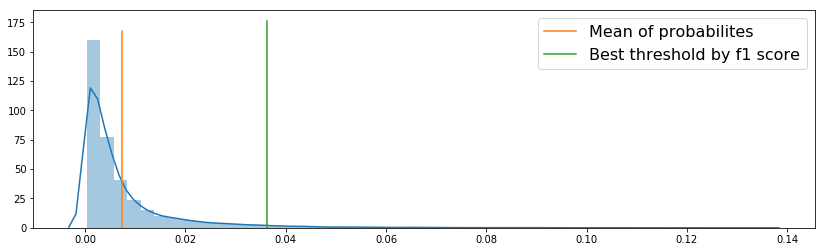

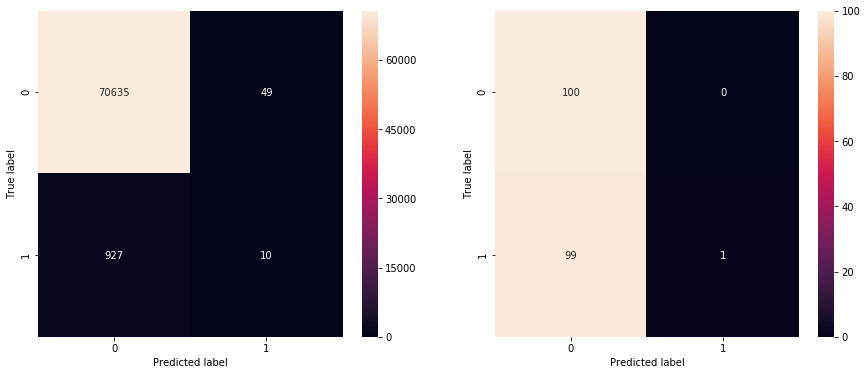

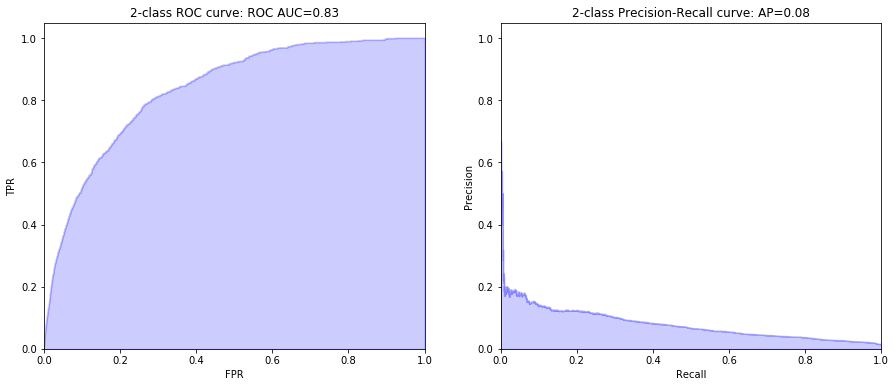

In [212]:
%%time 

prediction = prediction_proba[:, 1] > 0.1#get_threshold_by_f1(prediction_proba, y_test, plot=True)
plot_probas(prediction_proba, y_test)

get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

In [ ]:
keras.layers.Add()([x1, x2])

In [85]:
from keras.models import Sequential
from keras.layers import Add, Activation, Dense, Concatenate
from keras.layers.recurrent import LSTM
from keras.layers.merge import concatenate

In [88]:
from keras.layers import merge

In [93]:
first_input = Input(shape=(3, ))
first_dense = Dense(1, )(first_input)

second_input = Input(shape=(10, ))
second_emb = Embedding(output_dim=20, input_dim=5, mask_zero=True,  input_length=10)

second_model.add(Embedding(output_dim=20, input_dim=5, mask_zero=True,  input_length=10))
second_model.add(LSTM(20))
second_model.add(Dense(1))

third_input = Input(shape=(1, ))
merged = concatenate([first_dense, second])

# model = Sequential()
# model.add(merged)
    # optional instead\in addition to Dense in the 2 sub-models : model.add(Dense(1))
# model.add(Activation('softmax')) 

# # Dense
# dense_out = Dense(no_of_classes, activation='softmax')(merged)

# build and compile model
#model = Model(inputs=[input_1, input_2], outputs=[dense_out])

model.compile(optimizer='RMSprop', loss='binary_crossentropy')
print(model.summary())

AttributeError: 'Concatenate' object has no attribute 'compile'

In [109]:
DATA

,Time,ID,KORREKTUR,RECHNUNGSBETRAG,ALTER,GESCHLECHT,VERSICHERUNG,FACHRICHTUNG,NUMMER,NUMMER_KAT,TYP,ANZAHL,FAKTOR,BETRAG,ART,LEISTUNG,target,VISITS
0,0,ID_1,0.0,330.970001,53.570385,0,1,1,A_178,AA_10,0.0,2,2.30,24.400000,NaN,C_1,0,6
1,2264710,ID_1,0.0,330.970001,53.570385,0,1,1,A_1884,AA_2,0.0,1,2.30,13.410000,NaN,C_1,0,6
2,2788255,ID_1,0.0,330.970001,53.570385,0,1,1,A_1,AA_2,0.0,1,2.30,10.720000,NaN,C_1,0,6
3,2883467,ID_1,0.0,330.970001,53.570385,0,1,1,A_168,AA_10,0.0,1,2.50,23.020000,NaN,C_1,0,6
4,2985049,ID_1,0.0,330.970001,53.570385,0,1,1,A_172,AA_10,0.0,1,2.30,24.400000,NaN,C_1,0,6
5,2987411,ID_1,0.0,330.970001,53.570385,0,1,1,A_174,AA_10,0.0,1,3.50,81.599998,NaN,C_1,0,6
6,1,ID_2,0.0,455.200012,83.382721,1,1,1,A_765,AA_13,0.0,1,1.15,2.010000,NaN,C_6,0,41
7,107417,ID_2,0.0,455.200012,83.382721,1,1,1,A_764,AA_13,0.0,1,1.15,2.010000,NaN,C_6,0,41
8,205295,ID_2,0.0,455.200012,83.382721,1,1,1,A_1257,AA_3,0.0,3,3.50,48.959999,NaN,C_1,0,41
9,215788,ID_2,0.0,455.200012,83.382721,1,1,1,A_777,AA_13,0.0,1,1.15,0.000000,NaN,C_6,0,41


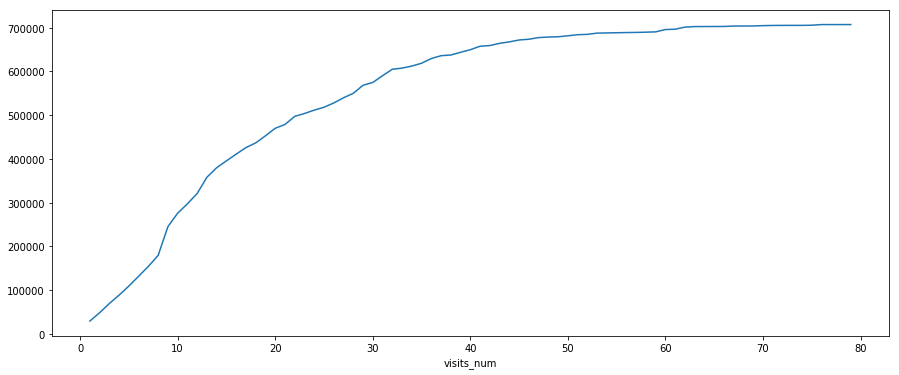

In [108]:
plt.figure(figsize=(15, 6))
targets[targets.visits_num<80].groupby('visits_num').KORREKTUR.sum().cumsum().plot()

In [79]:
X1 = np.random.randn(300).reshape(100, 3)
X2 = np.array([np.random.randint(5, size=10) for i in range(100)])
y = np.random.randint(2, size=100).reshape(-1, 1)

In [80]:
X1.shape, X2.shape, y.shape

((100, 3), (100, 10), (100, 1))

In [82]:
model.fit([X1, X2], y, batch_size=8, epochs=10)

AssertionError: 

Algorithm:
    1. Randomly split ID-s of train and test into 2 parts
    2. Choose separator to devide past (train data) and future (test data).
    
     All    |+|-| < Train
    data    -----
            |-|+| < Test
            
          ---------> 
             Time